# Install the YOLOV5 folder

In [1]:
import os
import shutil
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
from codecarbon import OfflineEmissionsTracker
from IPython.display import Audio

if not os.path.exists("yolov5"):
    !git clone https://github.com/ultralytics/yolov5
else:
    print("The yolov5 repository has been cloned.")
pathInicial=os.getcwd()  
os.chdir("yolov5")
import torch
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

The yolov5 repository has been cloned.
Setup complete. Using torch 1.12.1+cu113 _CudaDeviceProperties(name='Quadro RTX 4000', major=7, minor=5, total_memory=7982MB, multi_processor_count=36)


# We see if we have the data in place.

In [2]:
if not os.path.exists("../DatasetMobilityAid/dataYOLOv5"):
    print("You have to follow the instructions in Readme.md for Dataset Mobility Aid and download the data")
else:
    print("Good,¡The data is already in place!")

Good,¡The data is already in place!


# We apply data reduction
You must select one of the possible methods:

- NONE
- SRS
- DES
- MMS
- NRMD
- RKM
- PRD
- FES

You must select a reduction rate, for example if you want a reduction rate of 75%, you have to insert 0.25 in perc, that is to remain only with the 25% of full data.

In [ ]:
os.chdir(pathInicial)
method = "PHL"
perc=0.1
!python ReductionDatasetMobilityAid.py --name {method} --perc {perc}

# We updated the data yaml, in order to correctly run the training and evaluation of the model with the reduced data.

In [5]:
os.chdir("DatasetMobilityAid/dataYOLOv5")

import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

Original Yaml
names:
- pedestrian
- wheelchair
- push_wheelchair
- crutches
- walking-frame
nc: 5
test: ../DatasetMobilityAid/dataYOLOv5/test/images
train: ../DatasetMobilityAid/dataYOLOv5/train/images
val: ../DatasetMobilityAid/dataYOLOv5/test/images


In [6]:
%%writetemplate data.yaml
names:
- pedestrian
- wheelchair
- push_wheelchair
- crutches
- walking-frame
nc: 5
test: ../DatasetMobilityAid/dataYOLOv5/test/images
train: ../DatasetMobilityAid/dataYOLOv5/train/images
val: ../DatasetMobilityAid/dataYOLOv5/test/images

#  We train YOLOV5 on our reduced dataset

In [ ]:
os.chdir(pathInicial + '/yolov5')
for i in range(5): #different seed
    tracker = OfflineEmissionsTracker(country_iso_code="ESP",log_level="ERROR")
    tracker.start()
    seed=i
    comando = f"python train.py --img 640 --batch 16 --epochs 50 --data ../DatasetMobilityAid/dataYOLOv5/data.yaml --weights yolov5m.pt --freeze 10 --name yolov5_results_mobilityaid_{method}_{perc}_{seed} --cache --seed {seed}"
    !{comando}
    print("Estimated emissions: ", tracker.stop() * 1000, " CO2 grams")
    os.remove("emissions.csv")

# Evaluating the performance of our customized YOLOV5

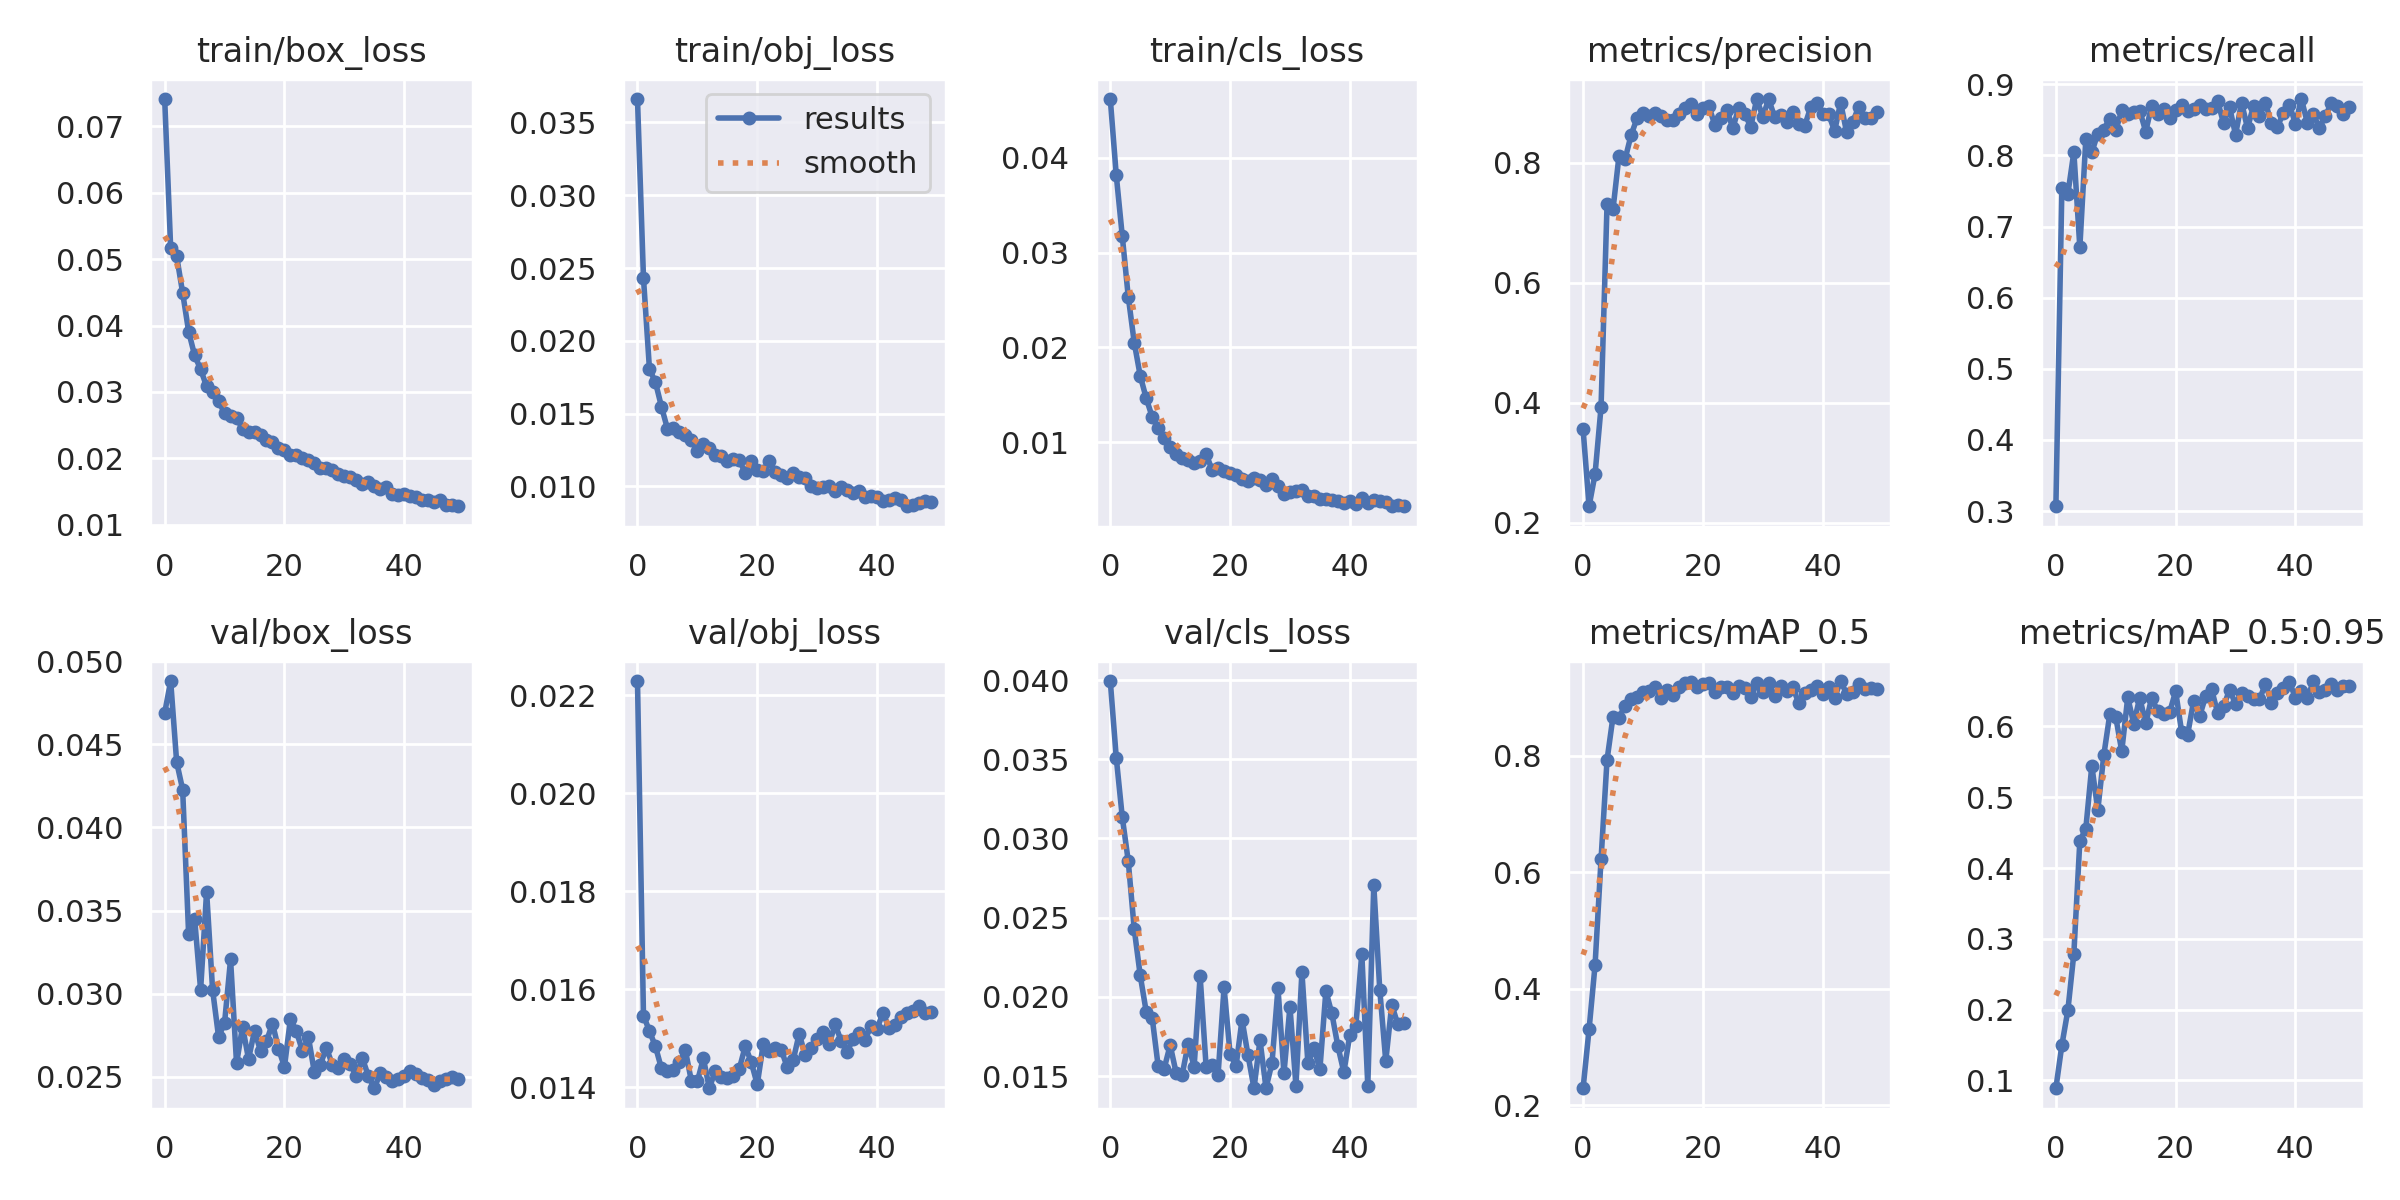

In [9]:
from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename=f'runs/train/yolov5_results_mobilityaid_{method}_{perc}_{seed}/results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


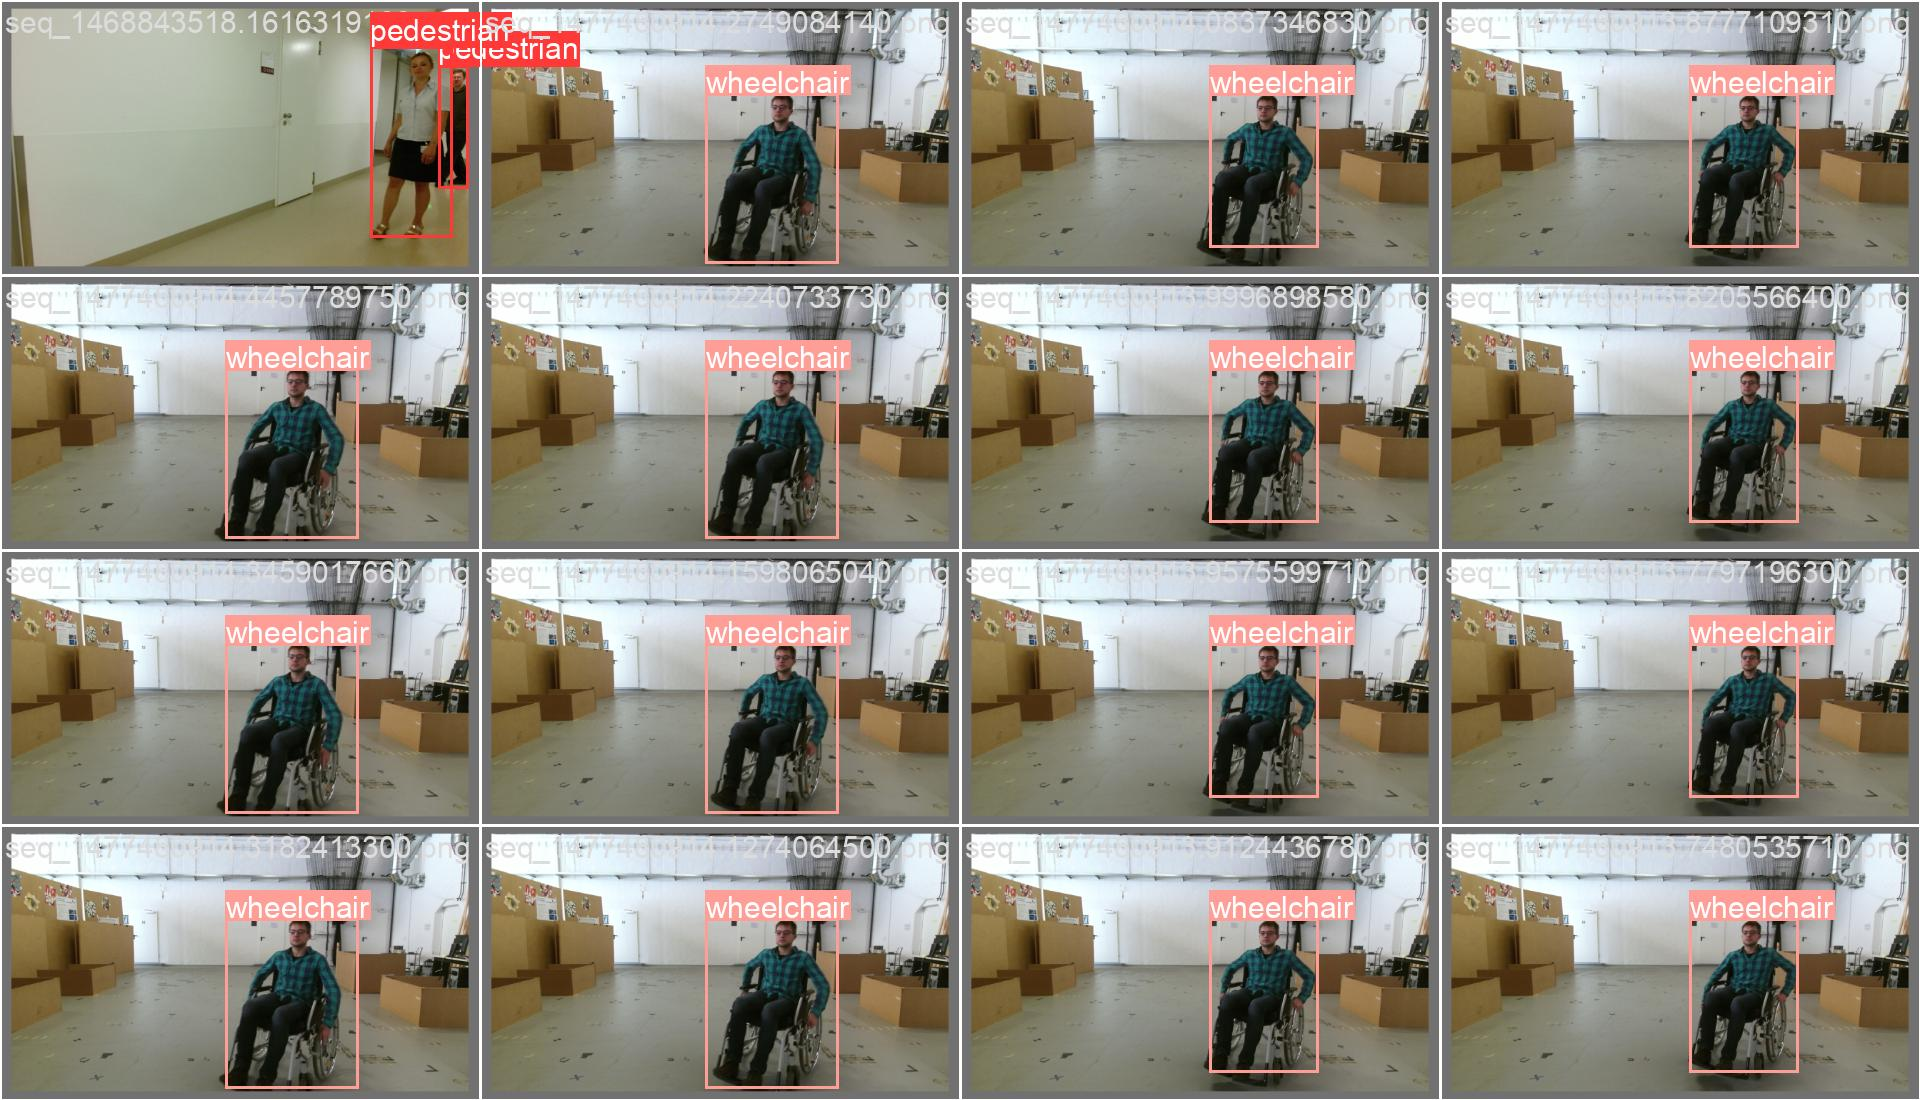

In [12]:
print("GROUND TRUTH TRAINING DATA:")
Image(filename=f'runs/train/yolov5_results_mobilityaid_{method}_{perc}_{seed}/val_batch0_labels.jpg', width=900)

# We make inference with our trained weights (with the best model).

In [ ]:
comando = f'python detect.py --weights runs/train/yolov5_results_mobilityaid_{method}_{perc}_{seed}/weights/best.pt --img 416 --conf 0.4 --source ../DatasetMobilityAid/dataYOLOv5/test/images'
!{comando}

detect: weights=['runs/train/yolov5_results_mobilityaid_SRS_0.1_0/weights/best.pt'], source=../Dataset2/dataYOLOv5/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-284-g95ebf68f Python-3.9.18 torch-1.12.1+cu113 CUDA:0 (Quadro RTX 4000, 7982MiB)

Fusing layers... 
Model summary: 212 layers, 20869098 parameters, 0 gradients, 47.9 GFLOPs
image 1/6118 /home/vtoscano/Investigacion/repoNuevo/Dataset2/dataYOLOv5/test/images/seq_1468843518.1616319190.png: 256x416 2 pedestrians, 13.4ms
image 2/6118 /home/vtoscano/Investigacion/repoNuevo/Dataset2/dataYOLOv5/test/images/seq_1468843518.2023388750.png: 256x416 2 pedes

# We show the inference for all the test images

In [16]:
import glob
for imageName in glob.glob('runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")